In [ ]:
import sys, os
sys.path.append("../model/")
sys.path.append("../datasets/")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
from train import getprobs
import numpy as np
import torch
from torch.utils.data import DataLoader
import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import json
from scipy import interpolate
from matplotlib import pyplot as plt
from tqdm import tqdm
import mpl_scatter_density
%env HDF5_USE_FILE_LOCKING=FALSE

In [ ]:
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"
all_models = [f for f in os.listdir(saved_model_loc) if "_best" in f and "_trial" not in f and 'MSE_massMasked' in f]
print("\n".join(all_models))

In [ ]:
dataset = 'jetnet' # 'topdata'
if dataset == 'topdata':
    true_classes = [0, 1] # 0:QCD, 1:top
if dataset == 'jetnet':
    true_classes = [0, 1, 2, 3, 4] # 0: g, 1:q, 2:t, 3:w, 4:z
test_path = "../datasets/" + dataset + "/test.h5"
#Loading testing dataset
test_set = PFINDataset(test_path)
testloader = DataLoader(test_set, shuffle=False, batch_size=512, num_workers=8, pin_memory=True, persistent_workers=True)

In [ ]:
def eval2(model, testloader, dataset='topdata'):
    labels = []
    preds = []
    sums = []
    latents = []
    ood = []
    with torch.no_grad():
        for x,m,a,y in tqdm(testloader):
            if dataset == 'jetnet':
                x = torch.cat([x, torch.zeros_like(x)], 1)
                m = torch.cat([m, torch.zeros_like(m)], 2)
            x = x.cuda()
            m = m.cuda()
            a = a.cuda()
            pred = model(x, a, m)
            s = (pred + 1).sum(-1)
            pred = getprobs(pred)
            labels.append(np.argmax(y.cpu().numpy(), axis=1))
            preds.append(pred[:,1].cpu().numpy())
            sums.append(s.cpu().numpy())
            ood.append( ((a[:,1] < 75.) | (a[:,1] > 95.)).float().cpu().numpy() )
            # latents.append(L.cpu().numpy())
    labels = np.concatenate(labels, axis=None)
    preds = np.concatenate(preds, axis=None)
    sums = np.concatenate(sums, axis=None)
    ood = np.concatenate(ood, axis=None)
    # latents = np.concatenate(latents, axis=0)
    return labels, preds, sums, ood

In [ ]:
model_results = {}
for modelname in all_models:
    print(modelname)
    model_dict = json.load(open(saved_model_dict_loc + modelname.replace("_best","") + ".json"))
    Np = model_dict['Np']
    phi_nodes = list(map(int, model_dict['phi_nodes'].split(',')))
    f_nodes = list(map(int, model_dict['f_nodes'].split(',')))
    label = model_dict['label']
    n_phiI = model_dict['n_phiI']
    x_mode = model_dict['x_mode']

    model = Model(particle_feats = 3,
                  n_consts = Np,
                  PhiI_nodes = n_phiI,
                  interaction_mode = x_mode,
                  Phi_sizes = phi_nodes,
                  F_sizes   = f_nodes).cuda()

    model.load_state_dict(torch.load(saved_model_loc + modelname ))
    nparams = sum(p.numel() for p in model.parameters())


    labels, preds, sums, ood = eval2(model, testloader, dataset = dataset)
    model_results[label] = {'labels' : labels, 'preds':preds, 'sums':sums, 'ood':ood}

In [ ]:
all_keys = list(model_results.keys())
all_keys

In [ ]:
_ = plt.scatter(model_results['baseline_MSE_massMasked_0.1']['preds'][:10000], 
                2./model_results['baseline_MSE_massMasked_0.1']['sums'][:10000], 
                s=0.8, 
                alpha=0.3, 
                marker='.')

In [ ]:
_ = plt.scatter(model_results['baseline_MSE_massMasked_0.1']['ood'][:10000], 
                2./model_results['baseline_MSE_massMasked_0.1']['sums'][:10000], 
                s=0.8, 
                alpha=0.3, 
                marker='.')

In [ ]:
_ = plt.hist2d(model_results['baseline_MSE_massMasked_0.1']['ood'][:10000], 
                model_results['baseline_MSE_massMasked_0.1']['labels'][:10000])
plt.colorbar()

In [ ]:
plt.hist(model_results['baseline_MSE_massMasked_0.1']['labels'][:10000])

In [ ]:
Nrows = 2 # predicted as 0->QCD or 1->top
Ncols = len(true_classes)

fig, axes = plt.subplots(Nrows, Ncols, figsize=(4*Ncols,4*Nrows), sharex = True, sharey = True)
fig2, axes2 = plt.subplots(Nrows, Ncols, figsize=(4*Ncols,4*Nrows), sharex = True, sharey = True)
fig3, axes3 = plt.subplots(Nrows, Ncols, figsize=(4*Ncols,4*Nrows), sharex = True, sharey = True)

for ii,key in enumerate(all_keys):
    labels, preds, sums = model_results[key]['labels'], model_results[key]['preds'], model_results[key]['sums']
    key = key.replace('baseline_MSE_', '')
    for jj in true_classes:
        all_indices = (labels == jj).sum()
        this_indices_0 = (labels == jj) & (preds < 0.5)
        this_indices_1 = (labels == jj) & (preds >= 0.5)
        f0 = this_indices_0.sum()/all_indices
        f1 = this_indices_1.sum()/all_indices
        axes[0, jj].hist(2./sums[this_indices_0], bins=np.arange(0.,1.01,0.04), label=key + ' ({:.2f})'.format(f0), alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[this_indices_0])) * np.ones_like(sums[this_indices_0]))
        axes[1,jj].hist(2./sums[this_indices_1], bins=np.arange(0.,1.01,0.04), label=key + ' ({:.2f})'.format(f1), alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[this_indices_1])) * np.ones_like(sums[this_indices_1]))
        
        axes2[0,jj].scatter(preds[this_indices_0], 2./sums[this_indices_0], label=key + ' ({:.2f})'.format(f0), alpha = 0.3, marker = '.', s = 0.2)
        axes2[1,jj].scatter(preds[this_indices_1], 2./sums[this_indices_1], label=key + ' ({:.2f})'.format(f1), alpha = 0.3, marker = '.', s = 0.2)
        
        axes3[0, jj].hist(preds[this_indices_0], bins=np.arange(0.,1.01,0.04), label=key + ' ({:.2f})'.format(f0), alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[this_indices_0])) * np.ones_like(sums[this_indices_0]))
        axes3[1,jj].hist(preds[this_indices_1], bins=np.arange(0.,1.01,0.04), label=key + ' ({:.2f})'.format(f1), alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[this_indices_1])) * np.ones_like(sums[this_indices_1]))

for ii,ax in enumerate(list(axes.flatten()) + list(axes3.flatten())  + list(axes2.flatten())):
    leg = ax.legend(loc='upper right',markerscale=16)
    if ii >= 4*Ncols:
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    else:
        ax.set_yscale('log')
            # lh._legmarker.set_markersize(16)

        
fig.supxlabel('Uncertainty Estimate', fontsize = 20)
fig.supylabel('Fraction of jets', fontsize = 20)
fig2.supxlabel('Predicted Probability', fontsize = 20)
fig2.supylabel('Uncertainty', fontsize = 20)
fig3.supxlabel('Predicted Probability', fontsize = 20)
fig3.supylabel('Fraction of jets', fontsize = 20)

In [46]:
axes.flatten()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

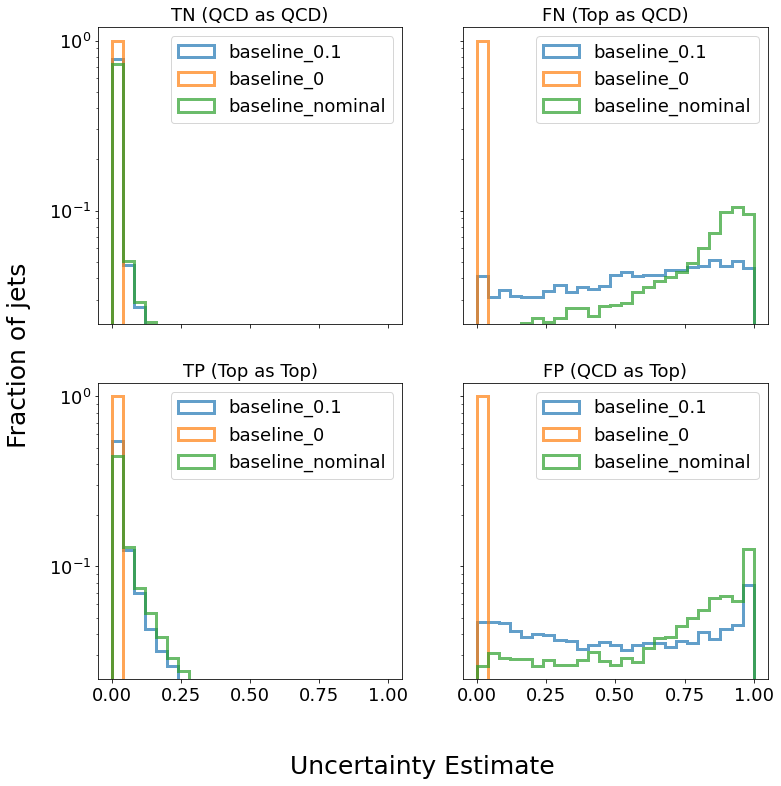

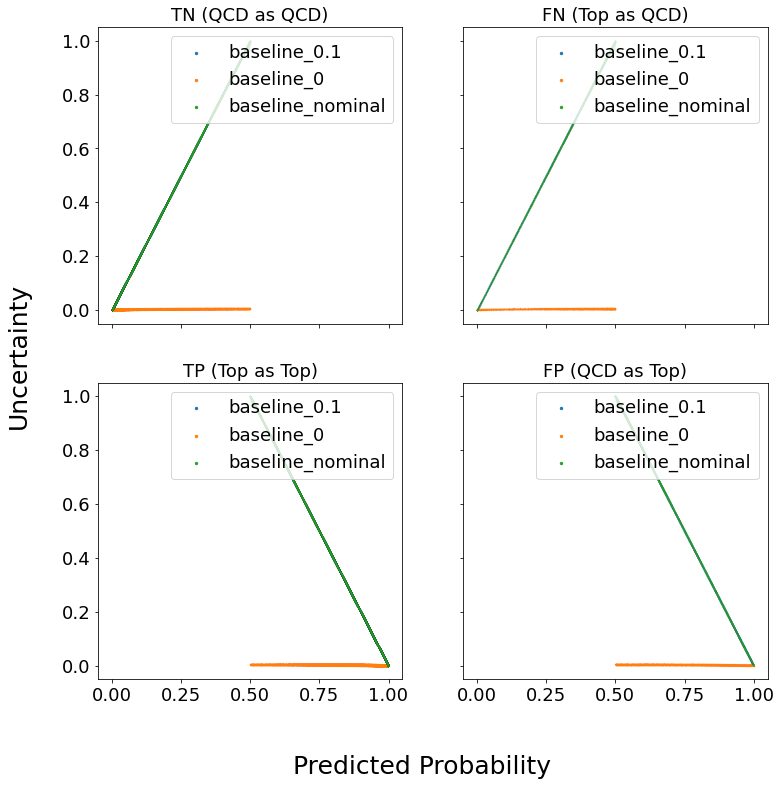

In [16]:
fig, ((tn, fn), (tp, fp)) = plt.subplots(2, 2, figsize=(12,12), sharex = True, sharey = True)

# fig2 = plt.figure(figsize=(12,12))
# tn2 = fig2.add_subplot(2, 2, 1, projection='scatter_density')
# fn2 = fig2.add_subplot(2, 2, 2, projection='scatter_density')
# tp2 = fig2.add_subplot(2, 2, 3, projection='scatter_density')
# fp2 = fig2.add_subplot(2, 2, 4, projection='scatter_density')
#colors = ['red', 'blue','green']
fig2, ((tn2, fn2), (tp2, fp2)) = plt.subplots(2, 2, figsize=(12,12), sharex = True, sharey = True)
for ii,key in enumerate(all_keys):
    labels, preds, sums = model_results[key]['labels'], model_results[key]['preds'], model_results[key]['sums']
    tn_indices = (labels == 0) & (preds < 0.5)
    fn_indices = (labels == 1) & (preds < 0.5)
    tp_indices = (labels == 1) & (preds >= 0.5)
    fp_indices = (labels == 0) & (preds >= 0.5)
    # bkg_indices = labels == 0
    # sig_indices = labels == 1
    
    tn.hist(2./sums[tn_indices], bins=np.arange(0.,1.01,0.04), label=key, alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[tn_indices])) * np.ones_like(sums[tn_indices]))
    fn.hist(2./sums[fn_indices], bins=np.arange(0.,1.01,0.04), label=key, alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[fn_indices])) * np.ones_like(sums[fn_indices]))
    
    tp.hist(2./sums[tp_indices], bins=np.arange(0.,1.01,0.04), label=key, alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[tp_indices])) * np.ones_like(sums[tp_indices]))
    fp.hist(2./sums[fp_indices], bins=np.arange(0.,1.01,0.04), label=key, alpha = 0.7, 
             histtype = 'step', linewidth = 3, weights = (1./len(sums[fp_indices])) * np.ones_like(sums[fp_indices]))
    
    tn2.scatter(preds[tn_indices], 2./sums[tn_indices], label=key, alpha = 0.3, marker = '.', s = 0.1)
    fn2.scatter(preds[fn_indices], 2./sums[fn_indices], label=key, alpha = 0.3, marker = '.', s = 0.1)
    tp2.scatter(preds[tp_indices], 2./sums[tp_indices], label=key, alpha = 0.3, marker = '.', s = 0.1)
    fp2.scatter(preds[fp_indices], 2./sums[fp_indices], label=key, alpha = 0.3, marker = '.', s = 0.1)

for ii, ax in enumerate([tn, fn, tp, fp, tn2, fn2, tp2, fp2]):
    leg = ax.legend(loc='upper right',fontsize=18, markerscale=15)
    ax.tick_params(axis='both', which='major', labelsize=18)
    if ii < 4:
        ax.set_yscale('log')
    if ii >=4:
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
tn.set_title('TN (QCD as QCD)', fontsize = 18)
fn.set_title('FN (Top as QCD)', fontsize = 18)
tp.set_title('TP (Top as Top)', fontsize = 18)
fp.set_title('FP (QCD as Top)', fontsize = 18)
tn2.set_title('TN (QCD as QCD)', fontsize = 18)
fn2.set_title('FN (Top as QCD)', fontsize = 18)
tp2.set_title('TP (Top as Top)', fontsize = 18)
fp2.set_title('FP (QCD as Top)', fontsize = 18)
fig.supxlabel('Uncertainty Estimate', fontsize = 25)
fig.supylabel('Fraction of jets', fontsize = 25)
fig2.supxlabel('Predicted Probability', fontsize = 25)
fig2.supylabel('Uncertainty', fontsize = 25)
plt.show()
    
    

In [17]:
from sklearn.decomposition import PCA

model2explore = "baseline_nominal"
labels, preds, sums, latents = model_results[model2explore]['labels'], model_results[model2explore]['preds'], \
                               model_results[model2explore]['sums'],   model_results[model2explore]['latents']


pca = PCA(n_components=0.99)
pca.fit(latents)

latents_pca = pca.fit_transform(latents)
latents_pca.shape


(404000, 52)

In [18]:
unc_thr = 0.8
bkg_indices = labels == 0
sig_indices = labels == 1
fp_indices_lu = (labels == 0) & (preds >= 0.5) & (2./sums > unc_thr)
fn_indices_lu = (labels == 1) & (preds < 0.5)  &  (2./sums > unc_thr)

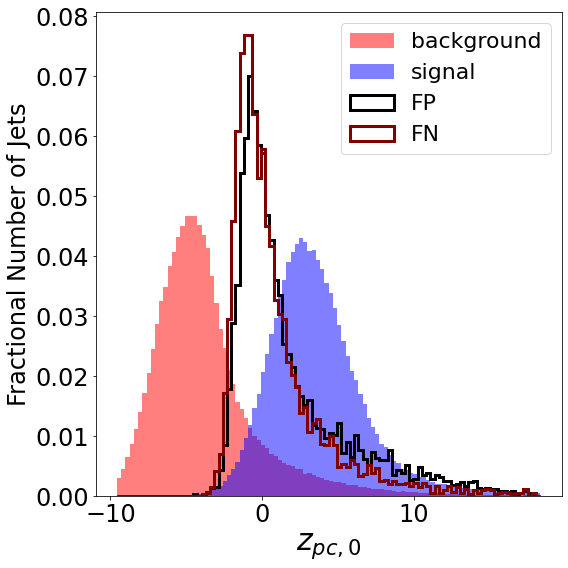

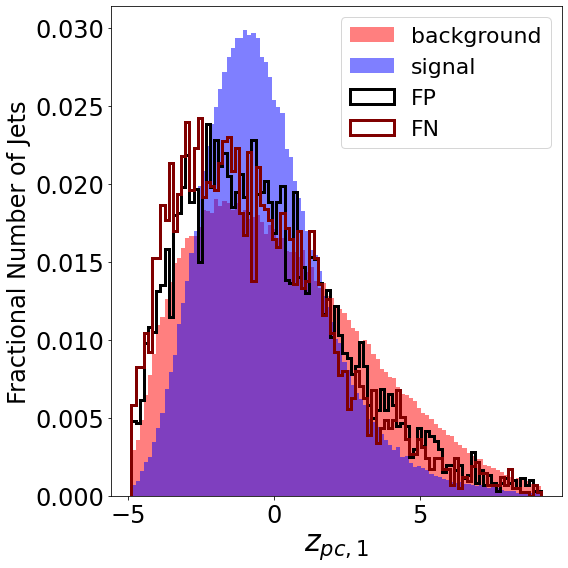

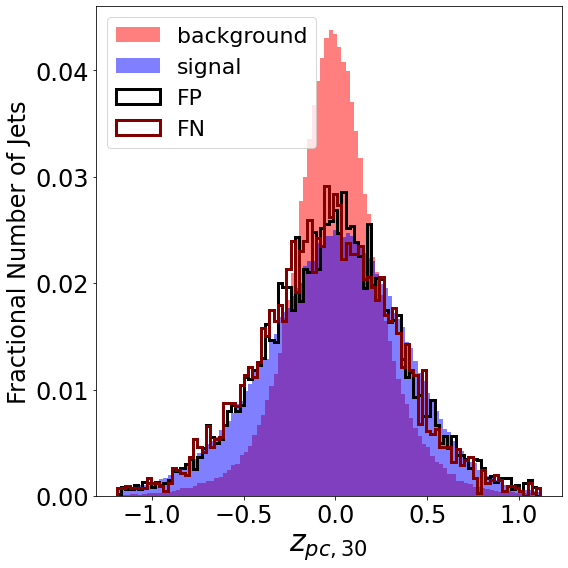

In [26]:
pc2plot = [0, 1, 30]
for ii in pc2plot:
    plt.figure(figsize=(8,8))
    bkg_data = latents_pca[bkg_indices, ii]
    sig_data = latents_pca[sig_indices, ii]
    fp_data = latents_pca[fp_indices_lu, ii]
    fn_data = latents_pca[fn_indices_lu, ii]
    
    mr = max(np.percentile(bkg_data, 99.5), np.percentile(sig_data, 99.5))
    ml = min(np.percentile(bkg_data, 0.5), np.percentile(sig_data, 0.5))
    m = mr - ml
    plt.hist(bkg_data, bins=np.arange(ml,mr,m/100), label='background', 
             color='red', alpha=0.5, weights = (1./len(bkg_data)) * np.ones_like(bkg_data))
    plt.hist(sig_data, bins=np.arange(ml,mr,m/100), label='signal', 
             color='blue', alpha=0.5, weights = (1./len(sig_data)) * np.ones_like(sig_data))
    
    plt.hist(fp_data, bins=np.arange(ml,mr,m/100), label='FP', 
             color='black',  histtype='step', linewidth = 3, 
             weights = (1./len(fp_data)) * np.ones_like(fp_data))
    plt.hist(fn_data, bins=np.arange(ml,mr,m/100), label='FN', 
             color='maroon', histtype='step', linewidth = 3, 
             weights = (1./len(fn_data)) * np.ones_like(fn_data))
    
    plt.xlabel('$z_{pc,' + '{}'.format(ii) + '}$', fontsize=30)
    plt.ylabel("Fractional Number of Jets", fontsize = 24)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.legend(fontsize = 22)
    plt.tight_layout()
    plt.show()
    #plt.savefig("figures/zpca_{}_{}.pdf".format(ii, label))

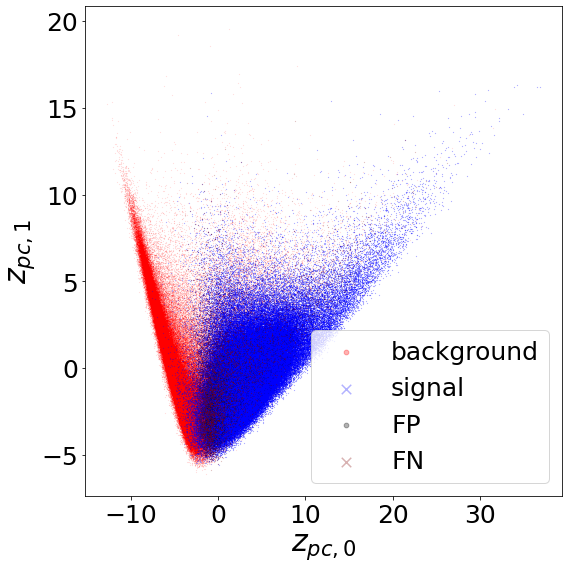

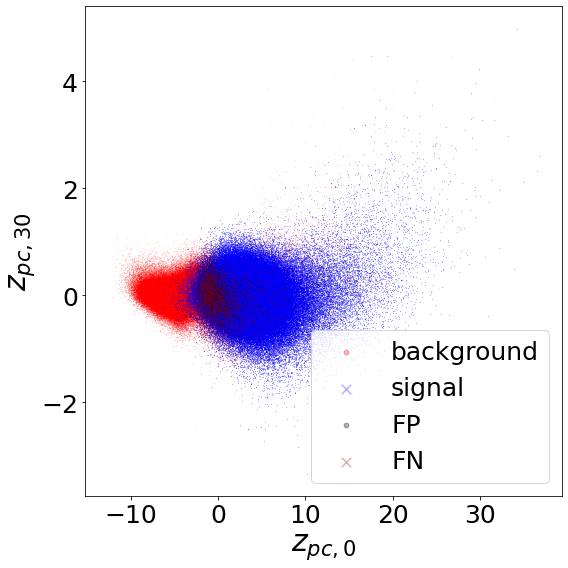

In [27]:
IDs = [(0,1), (0,30)]
Nsample = latents_pca.shape[0] # 30000

for (idx1, idx2) in IDs:
    plt.figure(figsize = (8,8))
    plt.scatter(latents_pca[bkg_indices, idx1][:Nsample], 
                latents_pca[bkg_indices, idx2][:Nsample], 
                color = 'red', marker = '.', label = 'background', 
                alpha=0.3, s = 0.1, rasterized=True)
    plt.scatter(latents_pca[sig_indices, idx1][:Nsample], 
                latents_pca[sig_indices, idx2][:Nsample], 
                color = 'blue', marker = 'x', label = 'signal', 
                alpha=0.3, s = 0.1, rasterized=True)
    plt.scatter(latents_pca[fp_indices_lu, idx1][:Nsample], 
                latents_pca[fp_indices_lu, idx2][:Nsample], 
                color = 'black', marker = '.', label = 'FP', 
                alpha=0.3, s = 0.1, rasterized=True)
    plt.scatter(latents_pca[fn_indices_lu, idx1][:Nsample], 
                latents_pca[fn_indices_lu, idx2][:Nsample], 
                color = 'maroon', marker = 'x', label = 'FN', 
                alpha=0.3, s = 0.1, rasterized=True)
    plt.xlabel('$z_{pc,' + '{}'.format(idx1) + '}$', fontsize=30)
    plt.ylabel('$z_{pc,' + '{}'.format(idx2) + '}$', fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=25)
    plt.legend(loc = 'lower right', markerscale = 30, fontsize = 25)
    plt.tight_layout()
    plt.show()
    # plt.savefig("figures/zpca{}_zpca{}.pdf".format(idx1, idx2))

